<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S10/EVA4_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import sys
import torch.nn as nn
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
!rm -rf '/content/drive/My Drive/colab_notebooks/S10/__pycache__'
!ls -lrt '/content/drive/My Drive/colab_notebooks/S10/'

total 1393
-rw------- 1 root root    1332 May 20 21:04 testing.py
-rw------- 1 root root    1644 May 30 06:06 train_test_loader.py
-rw------- 1 root root    4085 May 30 06:11 resnet18.py
-rw------- 1 root root   24582 Jun  6 17:30 lrfinder.py
-rw------- 1 root root    1117 Jun  6 18:20 get_images.py
drwx------ 2 root root    4096 Jun  6 18:21 data
-rw------- 1 root root    1731 Jun  6 18:55 training.py
-rw------- 1 root root     771 Jun  7 00:20 albumentation_transforms.py
-rw------- 1 root root 1376302 Jun  7 02:14 EVA4_S10.ipynb
-rw------- 1 root root     884 Jun 17 18:29 visualise_loss_acc.py
-rw------- 1 root root    6569 Jun 18 08:38 gradcam.py


##Add Google Drive path to system path

In [4]:
os.chdir('./drive/My Drive/colab_notebooks/S10/')

!ls

albumentation_transforms.py  get_images.py  resnet18.py  train_test_loader.py
data			     gradcam.py     testing.py	 visualise_loss_acc.py
EVA4_S10.ipynb		     lrfinder.py    training.py


##Import python files

In [5]:
import train_test_loader as ttl
import resnet18 as bm
import training as trn
import testing as tst
from lrfinder import LRFinder
import visualise_loss_acc as vis
import gradcam as gc
import get_images as gc_img

  pip install torch-lr-finder -v --global-option="amp"


##Main Function

In [6]:
def main(classes,dropout,lrate,momentum,batch_size,num_imgs,EPOCHS=50):

  train_loader, test_loader,test_transform = ttl.get_train_test(classes)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

  model = bm.ResNet18(dropout=dropout).to(device)
  summary(model, input_size=(3, 32, 32))

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lrate, momentum=momentum)

  ##LR FINDER##
  lr_finder = LRFinder(model, optimizer, criterion, device=device)
  lr_finder.range_test(train_loader,start_lr=1e-6, end_lr=1.4, num_iter=500, step_mode='exp')
  lr_finder.plot(log_lr=True)
  lr_finder.reset()

  best_loss = lr_finder.best_loss
  best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
  ##LR FINDER ENDS##

  ##RESET LR##
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=momentum)
  scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)
  ##RESET LR ENDS##
 
  test_loss=[]
  test_accuracy=[]
  train_loss=[]
  train_accuracy=[]
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch + 1)
      train_losses,train_acc=trn.train(model, device, train_loader, optimizer,EPOCHS,criterion,l1=1e-6,l2=1e-3)
      test_losses,test_acc=tst.test(model, device, test_loader,criterion)
      scheduler.step(test_losses[-1])

      test_loss.append(test_losses)
      test_accuracy.append(test_acc)

      train_loss.append(train_losses)
      train_accuracy.append(train_acc)
  
  vis.plot_acc_loss(test_loss,test_accuracy,train_loss,train_accuracy)
  
  ##gradcam##

  misclass=gc_img.get_images(model,device, test_loader,batch_size=batch_size,num_imgs=num_imgs)
  target_layers = ["layer1","layer2","layer3","layer4"]
  viz_cam = gc.VisualizeCam(model,classes, target_layers)

  num_img = len(misclass)

  incorrect_pred_imgs = []
  inc_image_for_gradcam = []
  for i in range(num_img):
    incorrect_pred_imgs.append(torch.as_tensor(misclass[i][0]))
    inc_image_for_gradcam.append(misclass[i])

  print('\n--GRADCAM FOR MISCLASSIFIED IMAGES--')
  viz_cam(torch.stack(incorrect_pred_imgs), inc_image_for_gradcam, target_layers, metric="incorrect")

##Calling Main

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
 


Learning rate search finished. See the graph with {finder_name}.plot()


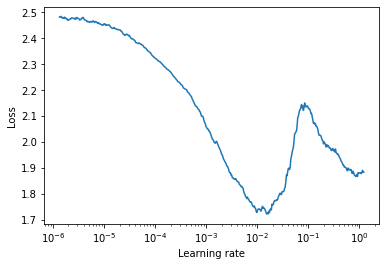

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.688275694847107 Batch_id=390 Accuracy=45.60: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 5730/10000 (57.30%)

EPOCH: 2


Loss=1.3776791095733643 Batch_id=390 Accuracy=64.51: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7056/10000 (70.56%)

EPOCH: 3


Loss=1.357944369316101 Batch_id=390 Accuracy=72.15: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7229/10000 (72.29%)

EPOCH: 4


Loss=1.1062636375427246 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7655/10000 (76.55%)

EPOCH: 5


Loss=1.150647759437561 Batch_id=390 Accuracy=78.81: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8088/10000 (80.88%)

EPOCH: 6


Loss=1.0487806797027588 Batch_id=390 Accuracy=81.14: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7920/10000 (79.20%)

EPOCH: 7


Loss=1.115132212638855 Batch_id=390 Accuracy=82.37: 100%|██████████| 391/391 [01:09<00:00,  5.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8302/10000 (83.02%)

EPOCH: 8


Loss=1.0704721212387085 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8499/10000 (84.99%)

EPOCH: 9


Loss=1.143769383430481 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8398/10000 (83.98%)

EPOCH: 10


Loss=1.0758726596832275 Batch_id=390 Accuracy=86.10: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8349/10000 (83.49%)

EPOCH: 11


Loss=1.0306406021118164 Batch_id=390 Accuracy=87.06: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8463/10000 (84.63%)

EPOCH: 12


Loss=0.9838715195655823 Batch_id=390 Accuracy=87.70: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8478/10000 (84.78%)

Epoch    12: reducing learning rate of group 0 to 1.5408e-03.
EPOCH: 13


Loss=0.7657702565193176 Batch_id=390 Accuracy=91.54: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8951/10000 (89.51%)

EPOCH: 14


Loss=0.7373696565628052 Batch_id=390 Accuracy=92.94: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9002/10000 (90.02%)

EPOCH: 15


Loss=0.751774787902832 Batch_id=390 Accuracy=93.20: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

EPOCH: 16


Loss=0.777725100517273 Batch_id=390 Accuracy=93.47: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8996/10000 (89.96%)

EPOCH: 17


Loss=0.7139981985092163 Batch_id=390 Accuracy=93.82: 100%|██████████| 391/391 [01:09<00:00,  5.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8990/10000 (89.90%)

EPOCH: 18


Loss=0.8636401891708374 Batch_id=390 Accuracy=94.26: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9002/10000 (90.02%)

EPOCH: 19


Loss=0.7958024740219116 Batch_id=390 Accuracy=94.14: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9017/10000 (90.17%)

EPOCH: 20


Loss=0.7076665759086609 Batch_id=390 Accuracy=94.69: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9016/10000 (90.16%)

Epoch    20: reducing learning rate of group 0 to 1.5408e-04.
EPOCH: 21


Loss=0.7776699066162109 Batch_id=390 Accuracy=94.98: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9028/10000 (90.28%)

EPOCH: 22


Loss=0.7807351350784302 Batch_id=390 Accuracy=94.97: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9020/10000 (90.20%)

EPOCH: 23


Loss=0.670228123664856 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9029/10000 (90.29%)

EPOCH: 24


Loss=0.7444990873336792 Batch_id=390 Accuracy=95.13: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9039/10000 (90.39%)

Epoch    24: reducing learning rate of group 0 to 1.5408e-05.
EPOCH: 25


Loss=0.6780670881271362 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9033/10000 (90.33%)

EPOCH: 26


Loss=0.6923326849937439 Batch_id=390 Accuracy=95.27: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9031/10000 (90.31%)

EPOCH: 27


Loss=0.6761213541030884 Batch_id=390 Accuracy=95.30: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9040/10000 (90.40%)

EPOCH: 28


Loss=0.6481450796127319 Batch_id=390 Accuracy=95.44: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9041/10000 (90.41%)

EPOCH: 29


Loss=0.7872111797332764 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9030/10000 (90.30%)

EPOCH: 30


Loss=0.7558758854866028 Batch_id=390 Accuracy=95.23: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9031/10000 (90.31%)

EPOCH: 31


Loss=0.7148003578186035 Batch_id=390 Accuracy=95.39: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9041/10000 (90.41%)

EPOCH: 32


Loss=0.6932527422904968 Batch_id=390 Accuracy=95.30: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9037/10000 (90.37%)

EPOCH: 33


Loss=0.7658411860466003 Batch_id=390 Accuracy=95.23: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9033/10000 (90.33%)

EPOCH: 34


Loss=0.8233404159545898 Batch_id=390 Accuracy=95.19: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9032/10000 (90.32%)

EPOCH: 35


Loss=0.8275479078292847 Batch_id=390 Accuracy=95.20: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9036/10000 (90.36%)

Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 36


Loss=0.7592270970344543 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [01:10<00:00,  5.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9038/10000 (90.38%)

EPOCH: 37


Loss=0.7787830829620361 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9048/10000 (90.48%)

EPOCH: 38


Loss=0.7635806798934937 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9046/10000 (90.46%)

EPOCH: 39


Loss=0.7591264247894287 Batch_id=390 Accuracy=95.32: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9037/10000 (90.37%)

EPOCH: 40


Loss=0.7339922189712524 Batch_id=390 Accuracy=95.32: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9029/10000 (90.29%)

EPOCH: 41


Loss=0.7021092176437378 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9034/10000 (90.34%)

EPOCH: 42


Loss=0.7488205432891846 Batch_id=390 Accuracy=95.36: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9033/10000 (90.33%)

EPOCH: 43


Loss=0.7300943732261658 Batch_id=390 Accuracy=95.23: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9029/10000 (90.29%)

EPOCH: 44


Loss=0.6850295662879944 Batch_id=390 Accuracy=95.39: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9045/10000 (90.45%)

EPOCH: 45


Loss=0.707150936126709 Batch_id=390 Accuracy=95.26: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9036/10000 (90.36%)

EPOCH: 46


Loss=0.6619818210601807 Batch_id=390 Accuracy=95.30: 100%|██████████| 391/391 [01:09<00:00,  5.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9037/10000 (90.37%)

EPOCH: 47


Loss=0.6356735229492188 Batch_id=390 Accuracy=95.16: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9034/10000 (90.34%)

EPOCH: 48


Loss=0.6918427348136902 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [01:09<00:00,  5.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9035/10000 (90.35%)

EPOCH: 49


Loss=0.7206223011016846 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9040/10000 (90.40%)

EPOCH: 50


Loss=0.7100256085395813 Batch_id=390 Accuracy=95.25: 100%|██████████| 391/391 [01:09<00:00,  5.60it/s]



Test set: Average loss: 0.0024, Accuracy: 9038/10000 (90.38%)


--GRADCAM FOR MISCLASSIFIED IMAGES--


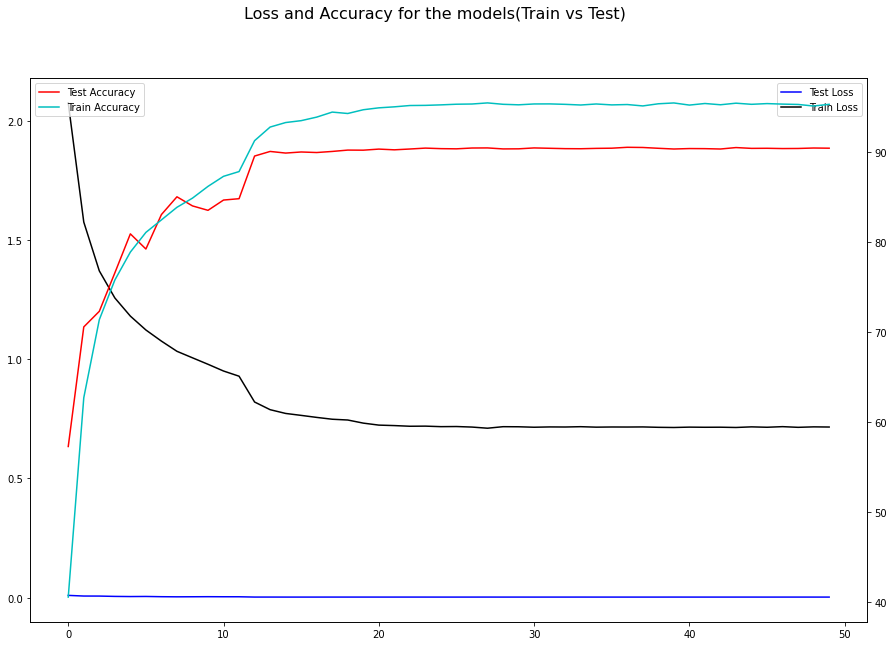

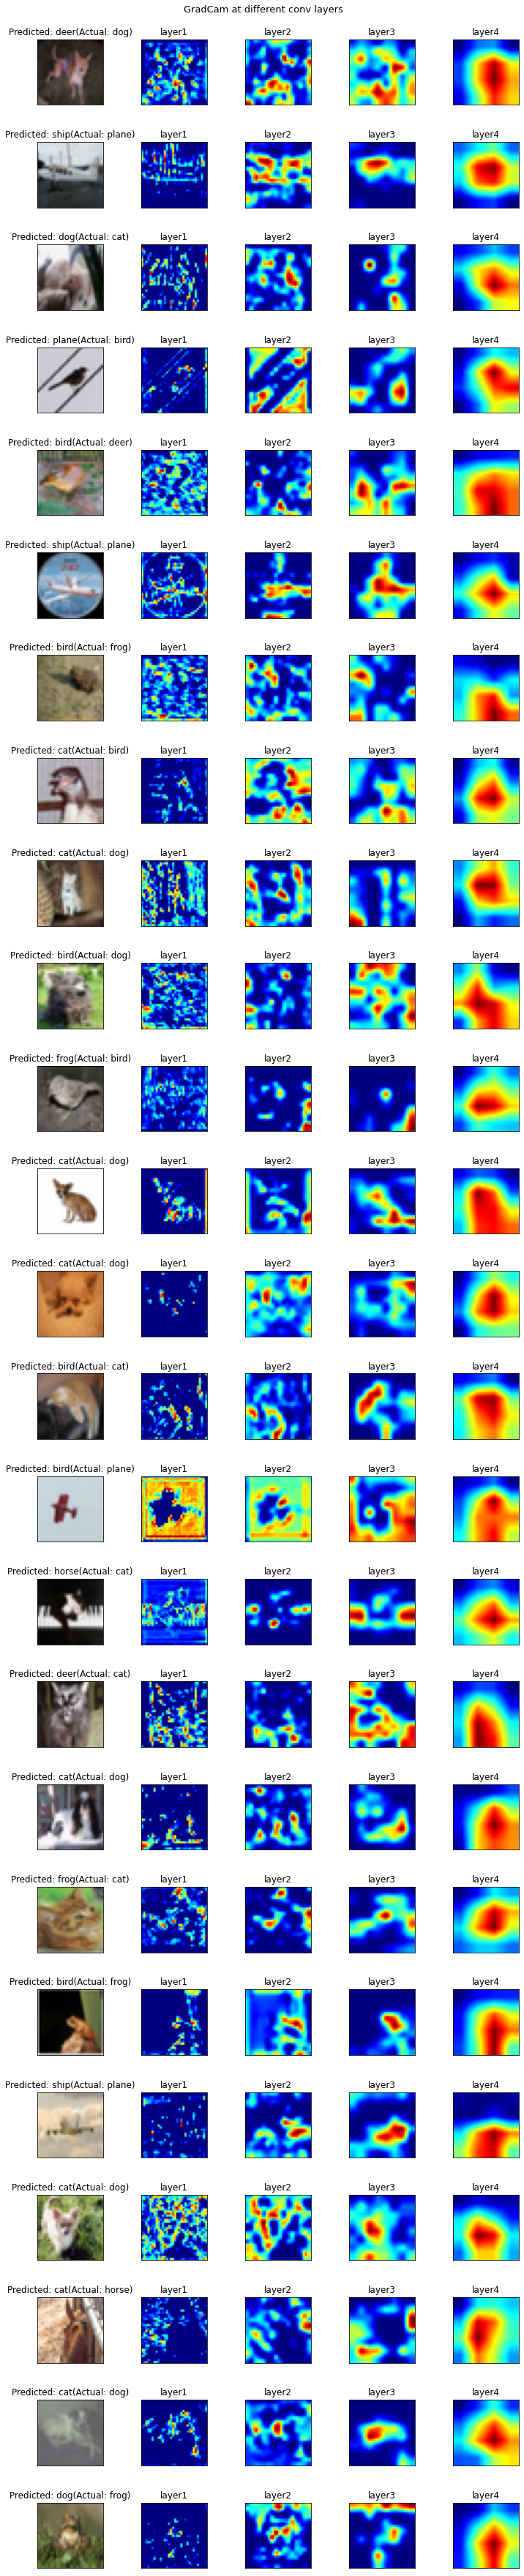

In [7]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
  
  dropout=0.15
  lrate=0.0001
  momentum=0.9
  batch_size=128
  num_imgs=25
  EPOCHS=50
  
  main(classes,dropout,lrate,momentum,batch_size,num_imgs,EPOCHS)